In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter


from sklearn import svm
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns

Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case, we are going to try to predict whether a sentence comes from _Alice in Wonderland_ by Lewis Carroll or _Persuasion_ by Jane Austen. We can use any of the supervised models we've covered previously, as long as they allow categorical outcomes. In this case, we'll try Random Forests, SVM, and KNN.

Our feature-generation approach will be something called _BoW_, or _Bag of Words_. BoW is quite simple: For each sentence, we count how many times each word appears. We will then use those counts as features.  

In [2]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

In [3]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [5]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !, I, shall, be, late, !, ')",Carroll
4,"((, when, she, thought, it, over, afterwards, ...",Carroll


Time to bag some words!  Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur.  We will exclude stopwords and punctuation.  In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

In [6]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [7]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500


,anew,hatter,prevent,snappishly,crawl,cheek,domestic,get,baldwin,lowing,...,consider,sink,dismay,remembrance,back,bit,bell,condemn,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !, I, shall, be, late, !, ')",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"((, when, she, thought, it, over, afterwards, ...",Carroll


## Trying out BoW

Now let's give the bag of words features a whirl by trying a random forest.

In [8]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.992290748899

Test set score: 0.90859030837


Holy overfitting, Batman! Overfitting is a known problem when using bag of words, since it basically involves throwing a massive number of features at a model – some of those features (in this case, word frequencies) will capture noise in the training set. Since overfitting is also a known problem with Random Forests, the divergence between training score and test score is expected.


## BoW with Logistic Regression

Let's try a technique with some protection against overfitting due to extraneous features – logistic regression with lasso.

In [9]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(2724, 3023) (2724,)
Training set score: 0.963656387665

Test set score: 0.935572687225


Logistic regression performs a bit better than the random forest.  

# BoW with Gradient Boosting

And finally, let's see what gradient boosting can do:

In [10]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.919970631424

Test set score: 0.908039647577


Looks like logistic regression is the winner, but there's room for improvement.

# Same model, new inputs

What if we feed the model a different novel by Jane Austen, like _Emma_?  Will it be able to distinguish Austen from Carroll with the same level of accuracy if we insert a different sample of Austen's writing?

First, we need to process _Emma_ the same way we processed the other data, and combine it with the Alice data:

In [11]:
# Clean the Emma data.
emma = gutenberg.raw('austen-emma.txt')
emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)
emma = text_cleaner(emma)
print(emma[:100])

Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to


In [12]:
# Parse our cleaned data.
emma_doc = nlp(emma)

In [13]:
# Group into sentences.
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]

# Emma is quite long, let's cut it down to the same length as Alice.
emma_sents = emma_sents[0:len(alice_sents)]

In [14]:
# Build a new Bag of Words data frame for Emma word counts.
# We'll use the same common words from Alice and Persuasion.
emma_sentences = pd.DataFrame(emma_sents)
emma_bow = bow_features(emma_sentences, common_words)

print('done')

Processing row 0
Processing row 500
Processing row 1000
done


In [15]:
# Now we can model it!
# Let's use logistic regression again.

# Combine the Emma sentence data with the Alice data from the test set.
X_Emma_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    emma_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_Emma_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Austen'] * emma_bow.shape[0])])

# Model.
print('\nTest set score:', lr.score(X_Emma_test, y_Emma_test))
lr_Emma_predicted = lr.predict(X_Emma_test)
pd.crosstab(y_Emma_test, lr_Emma_predicted)


Test set score: 0.703466666667


col_0,Austen,Carroll
row_0,,
Austen,1158,21
Carroll,535,161


Well look at that!  NLP approaches are generally effective on the same type of material as they were trained on. It looks like this model is actually able to differentiate multiple works by Austen from Alice in Wonderland.  Now the question is whether the model is very good at identifying Austen, or very good at identifying Alice in Wonderland, or both...

# Challenge 0:

Recall that the logistic regression model's best performance on the test set was 93%.  See what you can do to improve performance.  Suggested avenues of investigation include: Other modeling techniques (SVM?), making more features that take advantage of the spaCy information (include grammar, phrases, POS, etc), making sentence-level features (number of words, amount of punctuation), or including contextual information (length of previous and next sentences, words repeated from one sentence to the next, etc), and anything else your heart desires.  Make sure to design your models on the test set, or use cross_validation with multiple folds, and see if you can get accuracy above 97%.  

# Challenge 1:
Find out whether your new model is good at identifying Alice in Wonderland vs any other work, Persuasion vs any other work, or Austen vs any other work.  This will involve pulling a new book from the Project Gutenberg corpus (print(gutenberg.fileids()) for a list) and processing it.

Record your work for each challenge in a notebook and submit it below.

In [15]:
#Before trying anything else, let's try a SVC model to see if we can beat 93% from logistic...

from sklearn import svm
svc = svm.SVC()
svc.fit(X_train, y_train)
print("Score:", svc.score(X_test, y_test))

Score: 0.734030837004


In [200]:
#Try adding some common phrases (500 from each author) from the works into our dataframe


def text_phrases(text):
    noun_phrases = [np.text for np in text.noun_chunks]
    return [item[0] for item in Counter(noun_phrases).most_common(500)]


# Set up
alice_phrases = text_phrases(alice_doc)
persuasion_phrases = text_phrases(persuasion_doc)

# Combine bags to create a set of unique words.
common_phrases = set(alice_phrases + persuasion_phrases)

To the original code I have now added: number of words in sentence, num words in prior and next sentences, number of repeated words from last 
sentence, numbers of different parts of speech, numbers of different entity types, amount of punctuation, and phrases

Also added a feature to indicate presence of a word in ALL CAPS (seems to be part of Carroll's style)

In [267]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(4000)]
    


# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):

    #Get a list of all possible parts of speech and entities 
    #and attach this to our dataframe scaffold/structure, so that we can get counts

    partsofspeechlist = []
    ent_list = []

    for sent in range(len(sentences)):
        for tok in range(len(sentences[0][sent])):
            partsofspeechlist.append(sentences[0][sent][tok].pos_)
            ent_list.append(sentences[0][sent][tok].ent_type_)

    parts = (set(partsofspeechlist))
    ents = (set(ent_list))
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=set(list(common_words) + list(parts) + list(ents) + list(common_phrases)))
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    df['sent_length'] = 0
    df['sent_punct_count'] = 0 
    df['prev_sent_length'] = 0
    df['next_sent_length'] = np.nan
    df['num_words_repeated_from_prior_sent'] = 0
    df['upper_case'] = 0 
    df.loc[:, parts] = 0
    df.loc[:, ents] = 0
    df.loc[:, common_phrases] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        
        #Check to see if each phrase turns up in the sentence (store as binary var for the time being)
        
        for phrase in common_phrases:
            if phrase in str(sentence):
                df.loc[i, phrase] = 1
        
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        
        #Also add # of repeated words from one sentence to the next
        repeats = 0
        for word in words:
            df.loc[i, word] += 1
            if i > 0: 
                if ((df.loc[i-1, word] > 0) & (df.loc[i, word] > 0)):
                    repeats += 1
            else: 
                repeats = np.nan
        df['num_words_repeated_from_prior_sent'][i] = repeats
        
        #Add part of speech counter
        
        for token in sentence:
            df.loc[i, token.pos_] += 1
            df.loc[i, token.ent_type_] += 1
            
        #I also noticed that Carroll tends to use a lot of ALL UPPER CASE words, so I'll create a feature for that as well    
            if ((str(token).isupper()) & (len(str(token)) > 1)):
                df.loc[i, 'upper_case'] = 1

#My code -- calculate sentence length and amount of punctuation!

        sent_len = 0    
        num_punct = 0 
        
        for token in sentence:
            if not token.is_punct:
                sent_len += 1
            else:
                num_punct += 1
        df.loc[i, 'sent_length'] = sent_len
        df.loc[i, 'sent_punct_count'] = num_punct
        
        if i > 0:
            df.loc[i, 'prev_sent_length'] = df.loc[i-1, 'sent_length']
        else:
            df.loc[i, 'prev_sent_length'] = np.nan
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
    
    #Back out of the loop through sentences and just shift the df by one to get the "next sent len" feature
    df['next_sent_length'] = df['sent_length'].shift(-1) 
            
    return df

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [210]:
#Rebuild the word_counts df with our new features

# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

c:\users\ryan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\ryan\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500


,,squareness,the Musgroves,excited,a few hours,the dance,greatly,property,pigs,transmit,...,bell,condemn,text_sentence,text_source,sent_length,sent_punct_count,prev_sent_length,next_sent_length,num_words_repeated_from_prior_sent,upper_case
0,65,0,0,0,0,0,0,0,0,0,...,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll,57,10,NaN,56.0,NaN,0
1,61,0,0,0,0,0,0,0,0,0,...,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll,56,7,57.0,29.0,0.0,0
2,29,0,0,0,0,0,0,0,0,0,...,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll,29,4,56.0,6.0,1.0,1
3,9,0,0,0,0,0,0,0,0,0,...,0,0,"(Oh, dear, !, I, shall, be, late, !, ')",Carroll,6,3,29.0,109.0,2.0,0
4,122,0,0,0,0,0,0,0,0,0,...,0,0,"((, when, she, thought, it, over, afterwards, ...",Carroll,109,17,6.0,21.0,0.0,1


In [214]:
#Let's take a look at how the parts of speech compared between these two authors - step 1

viz_df = pd.DataFrame(word_counts.loc[:, parts])
viz_df['Source'] = word_counts['text_source']
viz_df.head()

,NOUN,X,PUNCT,NUM,ADV,PRON,PART,DET,CCONJ,ADJ,ADP,VERB,INTJ,PROPN,Source
0,12,0,9,0,3,3,3,5,6,3,8,13,0,2,Carroll
1,8,0,7,0,7,4,1,6,2,7,8,11,0,2,Carroll
2,2,0,4,0,1,2,1,3,1,2,6,5,2,4,Carroll
3,0,0,3,0,0,1,0,0,0,1,0,2,2,0,Carroll
4,15,0,17,0,11,13,5,11,8,5,18,19,0,4,Carroll


In [215]:
# Step 2

carroll_df = viz_df[viz_df['Source'] == 'Carroll'].groupby('Source').sum() / (len(alice_doc))
austen_df = viz_df[viz_df['Source'] == 'Austen'].groupby('Source').sum() / (len(persuasion_doc))
new_df = carroll_df.append(austen_df)
new_df.head()

,NOUN,X,PUNCT,NUM,ADV,PRON,PART,DET,CCONJ,ADJ,ADP,VERB,INTJ,PROPN
Source,,,,,,,,,,,,,,
Carroll,0.111198,0.000029,0.206852,0.005764,0.077693,0.082409,0.023986,0.084796,0.032923,0.060635,0.087940,0.181789,0.004628,0.039356
Austen,0.128021,0.000000,0.144349,0.005388,0.074930,0.074065,0.026129,0.069938,0.038827,0.090861,0.111723,0.182556,0.002288,0.050926


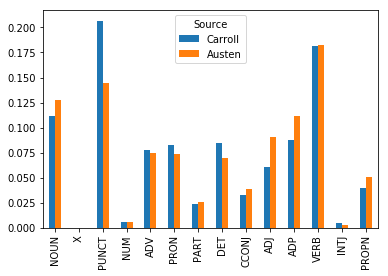

In [216]:
#Visualize the parts of speech distribution among each author

new_df.T.plot(kind = 'bar')

In [222]:
#Do not include SVC because it takes forever to run and it has poor performance
X2 = word_counts.dropna()

Y = np.array(X2['text_source'])
X = np.array(X2.drop(['text_sentence','text_source'], 1))

#Test accuracy using k-fold cross validation

from sklearn.model_selection import KFold

lrscore = []
rfcscore = []
gbmscore = []
svcscore = []

testno = 1

kf = KFold(n_splits=7, shuffle = True)
for train_index, test_index in kf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]


    lr = LogisticRegression()
    train = lr.fit(X_train, y_train)
    print('Test: ', testno, 'Logistic Train Score:', lr.score(X_train, y_train))
    print('Test: ', testno, 'Logistic Test Score:', lr.score(X_test, y_test))
    lrscore.append(lr.score(X_test, y_test))
    print('')

    rfc = ensemble.RandomForestClassifier()
    train = rfc.fit(X_train, y_train)
    print('Test: ', testno, 'RFC Train Score:', rfc.score(X_train, y_train))
    print('Test: ', testno, 'RFC Test Score:', rfc.score(X_test, y_test))
    rfcscore.append(rfc.score(X_test, y_test))
    print('')
    
    clf = ensemble.GradientBoostingClassifier()
    train = clf.fit(X_train, y_train)
    print('Test: ', testno, 'GBM Train Score:', clf.score(X_train, y_train))
    print('Test: ', testno, 'GBM Test Score:', clf.score(X_test, y_test))
    gbmscore.append(clf.score(X_test, y_test))
    print('')
    
    testno += 1
print('Average LR Score:', np.mean(lrscore))
print('Average RFC Score:', np.mean(rfcscore))
print('Average GBM Score:', np.mean(gbmscore))

Test:  1 Logistic Train Score: 0.980971972229
Test:  1 Logistic Test Score: 0.947611710324

Test:  1 RFC Train Score: 0.989714579583
Test:  1 RFC Test Score: 0.902927580894

Test:  1 GBM Train Score: 0.933916173824
Test:  1 GBM Test Score: 0.922958397535

Test:  2 Logistic Train Score: 0.979686294677
Test:  2 Logistic Test Score: 0.956856702619

Test:  2 RFC Train Score: 0.993314476729
Test:  2 RFC Test Score: 0.906009244992

Test:  2 GBM Train Score: 0.930830547699
Test:  2 GBM Test Score: 0.907550077042

Test:  3 Logistic Train Score: 0.980205655527
Test:  3 Logistic Test Score: 0.952160493827

Test:  3 RFC Train Score: 0.995372750643
Test:  3 RFC Test Score: 0.912037037037

Test:  3 GBM Train Score: 0.933161953728
Test:  3 GBM Test Score: 0.916666666667

Test:  4 Logistic Train Score: 0.982005141388
Test:  4 Logistic Test Score: 0.927469135802

Test:  4 RFC Train Score: 0.991516709512
Test:  4 RFC Test Score: 0.904320987654

Test:  4 GBM Train Score: 0.933676092545
Test:  4 GBM Test

In [223]:
#Try optimizing the RFC model
from sklearn.model_selection import GridSearchCV

X2 = word_counts.dropna()

Y = np.array(X2['text_source'])
X = np.array(X2.drop(['text_sentence','text_source'], 1))

# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30)

tuned_parameters = [{'penalty': ['l1', 'l2'],
                     'class_weight': ['balanced', None],
                     'C': [0.1, 1, 10, 100, 1000]}]
 
gscv = GridSearchCV(estimator = LogisticRegression(), param_grid = tuned_parameters, cv = 7, n_jobs = -1)
gscv.fit(X_train, y_train)
gscv.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [224]:
print('Best Logistic Regression Score:', gscv.best_score_)

Best Logistic Regression Score: 0.941435768262


In [217]:
#Try optimizing the RFC model
from sklearn.model_selection import GridSearchCV

X2 = word_counts.dropna()

Y = np.array(X2['text_source'])
X = np.array(X2.drop(['text_sentence','text_source'], 1))

# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30)

tuned_parameters = [{'n_estimators': [25, 100],
                     'max_features': [1, 3, None],
                     'max_depth': [1, 2, 5, None],
                     'criterion': ['gini', 'entropy']}]
 
gscv = GridSearchCV(estimator = ensemble.RandomForestClassifier(), param_grid = tuned_parameters, cv = 3, n_jobs = -1)
gscv.fit(X_train, y_train)
gscv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [219]:
print('Best RFC Score:', gscv.best_score_)

Best RFC Score: 0.923173803526


The models did not really improve very much - at least not our best model (logistic regression) - was not able to achieve
97% accuracy per the challenge.

Challenge mentions checking grammar. How would I go about doing that?
How can we leverage the dependency parser to improve our model?

Any other ideas?

In [227]:
#Challenge part 2: Incorporate another work. We'll see how well the model does in distinguishing between 3 authors.

print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [239]:
#Load in and clean a new book, using our text_cleaner function and the spacy load function
paradise = gutenberg.raw('milton-paradise.txt')
paradise = text_cleaner(paradise)

#Spacy load
paradise_doc = nlp(paradise)

In [262]:
#Extract and store sentences from spacy doc
paradise_sents = [[sent, 'Milton'] for sent in paradise_doc.sents]

#Add the paradise sentences to our existing sentences DF
sentences = pd.DataFrame(alice_sents + persuasion_sents + paradise_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !, I, shall, be, late, !, ')",Carroll
4,"((, when, she, thought, it, over, afterwards, ...",Carroll


In [264]:
#Start getting inputs ready to create new dataframe, which will be fed into our supervised models.

paradise_phrases = text_phrases(paradise_doc)

# Combine bags to create a set of unique words.
common_phrases = set(alice_phrases + persuasion_phrases + paradise_phrases)

In [265]:
# Set up the bag of words for paradise.
paradisewords = bag_of_words(paradise_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords + paradisewords)

In [268]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

c:\users\ryan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\ryan\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500


,,squareness,the Musgroves,excited,a few hours,the dance,greatly,Art,property,pigs,...,bell,condemn,text_sentence,text_source,sent_length,sent_punct_count,prev_sent_length,next_sent_length,num_words_repeated_from_prior_sent,upper_case
0,65,0,0,0,0,0,0,0,0,0,...,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll,57,10,NaN,56.0,NaN,0
1,61,0,0,0,0,0,0,0,0,0,...,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll,56,7,57.0,29.0,0.0,0
2,29,0,0,0,0,0,0,0,0,0,...,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll,29,4,56.0,6.0,1.0,1
3,9,0,0,0,0,0,0,0,0,0,...,0,0,"(Oh, dear, !, I, shall, be, late, !, ')",Carroll,6,3,29.0,109.0,2.0,0
4,122,0,0,0,0,0,0,0,0,0,...,0,0,"((, when, she, thought, it, over, afterwards, ...",Carroll,109,17,6.0,21.0,0.0,1


In [270]:
#Do not include SVC because it takes forever to run and it has poor performance
X2 = word_counts.dropna()

Y = np.array(X2['text_source'])
X = np.array(X2.drop(['text_sentence','text_source'], 1))

#Test accuracy using k-fold cross validation

from sklearn.model_selection import KFold

lrscore = []
rfcscore = []
gbmscore = []
svcscore = []

testno = 1

kf = KFold(n_splits=7, shuffle = True)
for train_index, test_index in kf.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    rfc = ensemble.RandomForestClassifier()
    train = rfc.fit(X_train, y_train)
    print('Test: ', testno, 'RFC Train Score:', rfc.score(X_train, y_train))
    print('Test: ', testno, 'RFC Test Score:', rfc.score(X_test, y_test))
    rfcscore.append(rfc.score(X_test, y_test))
    print('')
    
    testno += 1

print('Average RFC Score:', np.mean(rfcscore))

Test:  1 RFC Train Score: 0.994670456564
Test:  1 RFC Test Score: 0.841320553781

Test:  2 RFC Train Score: 0.993249244981
Test:  2 RFC Test Score: 0.850905218317

Test:  3 RFC Train Score: 0.99431616341
Test:  3 RFC Test Score: 0.855010660981

Test:  4 RFC Train Score: 0.99325044405
Test:  4 RFC Test Score: 0.847547974414

Test:  5 RFC Train Score: 0.994138543517
Test:  5 RFC Test Score: 0.858208955224

Test:  6 RFC Train Score: 0.992362344583
Test:  6 RFC Test Score: 0.841151385928

Test:  7 RFC Train Score: 0.992717584369
Test:  7 RFC Test Score: 0.852878464819

Average RFC Score: 0.84957474478


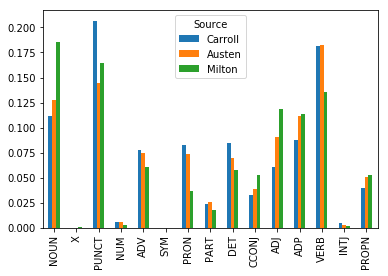

In [290]:
#Visualize the parts of speech distribution among each author
viz_df = pd.DataFrame(word_counts.loc[:, parts])
viz_df['Source'] = word_counts['text_source']
carroll_df = viz_df[viz_df['Source'] == 'Carroll'].groupby('Source').sum() / (len(alice_doc))
austen_df = viz_df[viz_df['Source'] == 'Austen'].groupby('Source').sum() / (len(persuasion_doc))
milton_df = viz_df[viz_df['Source'] == 'Milton'].groupby('Source').sum() / (len(paradise_doc))
new_df = carroll_df.append(austen_df).append(milton_df)

new_df.T.plot(kind = 'bar')

In [299]:
#Double-check the accuracy of the final model (testing between 3 authors)
X2 = word_counts.dropna()

Y = np.array(X2['text_source'])
X = np.array(X2.drop(['text_sentence','text_source'], 1))

from sklearn import ensemble 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, random_state = 0)
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)
print('\nTest set score:', rfc.score(X_test, y_test))
pred = rfc.predict(X_test)


Test set score: 0.841324200913
